In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost==0.23.2
!pip install xgbfir==0.3.1
# !pip install eli5==0.8.1
!pip install --upgrade tables

     |████████████████████████████████| 64.7MB 57kB/s 
     |████████████████████████████████| 153kB 6.2MB/s 
     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 81kB 4.9MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any.whl size=26308 sha256=3f7fa29b3562560c43c0df9267a6ed7fd8c1a7db1b8b21f20c78a017d812ab12
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
Successfully built typing


     |████████████████████████████████| 4.3MB 5.1MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [1]:
import pandas as pd
import numpy as np
import gc
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import re
from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve, train_test_split, KFold

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import xgbfir
# import eli5
%matplotlib inline

In [2]:
train = pd.read_hdf('/content/drive/MyDrive/ML/PML8_course/input/train.v4.h5')
test = pd.read_hdf('/content/drive/MyDrive/ML/PML8_course/input/test.v4.h5') # test set without price

train.fillna('-1', inplace=True)
test.fillna('-1', inplace=True)

df_all = pd.concat([train, test], sort=False)

In [3]:
df_all['Security:_group'] = df_all['Security:'].str.lower()
# df_all['Security:_group'].fillna('-1', inplace=True)
df_all.loc[df_all['Security:_group'].str.contains('24|round'), 'Security:_group'] = 'full'

condition = df_all['Security:_group'].isin(['provided', 'is'])
df_all.loc[condition, 'Security:_group'] = 'yes'
df_all.loc[df_all['Security:_group'].str.contains('security|guard|protected|secure'), 'Security:_group'] = 'yes'

condition = df_all['Security:_group'].isin(['fenced area', 'enclosed courtyard', 'ogorojennaja territory'])
df_all.loc[condition, 'Security:_group'] = 'closed area'

df_all.loc[df_all['Security:_group']=='not allowed', 'Security:_group'] = 'no'
df_all.loc[df_all['Security:_group']=='cat t', 'Security:_group'] = 'video surveillance'

condition = df_all['Security:_group'].isin(['concierge, intercom', 'concierge. doorphone.']) 
df_all.loc[condition, 'Security:_group'] = 'concierge'

condition = df_all['Security:_group'].isin(['-1', 'yes', 'closed area', 'full', 'video surveillance', 'concierge', 'no'])
df_all.loc[~condition, 'Security:_group'] = 'some'

In [4]:
#Change columns with list to string. (except date)
col_list = ['breadcrumbs', 'geo_block', 'owner']
for column in col_list:
    df_all['{}_str'.format(column)] = df_all[column].map(lambda x: ','.join(x))

In [5]:
df_all['owner_str_group'] = df_all['owner_str'].str.lower()
df_all.loc[df_all['owner_str_group'].str.contains('@'), 'owner_str'] = 'priv'
counts = df_all['owner_str_group'].value_counts()
mask = df_all['owner_str_group'].isin(counts[counts < 5].index)
df_all.loc[mask, 'owner_str_group'] = 'other'

In [6]:
def bread_geo_func(row): #concatenate breadcrumbs with geo_block, erase repeated values
    bread_str = ','.join(row['breadcrumbs']).lower().strip()
    geo_str = ','.join(row['geo_block']).lower().strip()
    bread_geo_str = (bread_str +','+ geo_str).replace('.', '')
    # .replace('ул.', 'ул').replace('пер.', 'пер').replace('пр-кт.', 'пр-кт').\
    #             replace('проезд.', 'проезд').replace('б-р.', 'б-р')
    
    bread_geo = ','.join(sorted(list(set(bread_geo_str.split(',')) - set(['москва', 'г москва']))))
    
    return bread_geo

df_all['bread_geo_str'] = df_all[['breadcrumbs', 'geo_block']].apply(bread_geo_func, axis=1)

In [7]:
def metro_func(row):
    metro = [i for i in row['bread_geo_str'].split(',') if ('мцк ' in i)]
    if len(metro)>0 :
        return ','.join(metro)
    return 'missing'
df_all['metro_str'] = df_all[['bread_geo_str']].apply(metro_func, axis=1)

In [8]:
def station_func(row):
    station = [i for i in row['bread_geo_str'].split(',') if ('м ' in i)]
    if len(station)>0 :
        return ','.join(station)
    return 'missing'
df_all['station'] = df_all[['bread_geo_str']].apply(station_func, axis=1)

In [9]:
def street_func(row):
    street_ext = ['ул ', 'б-р', 'пер ', 'пр-кт', 'аллея ', 'проезд ', 'ш ', 'пл ', 'наб ']
    street = [i for i in row['bread_geo_str'].split(',') if any(ext in i for ext in street_ext)]
    if len(street)>0 :
        return ','.join(street)
    return 'missing'
df_all['street'] = df_all[['bread_geo_str']].apply(street_func, axis=1)

In [10]:
df_all['new_moscow_cat'] = df_all['bread_geo_str'].map(lambda x: 1 if 'новая москва' in x else 0)

In [11]:
def bread_geo_others(row):
    new_cols = row['metro_str'].split(',') + row['station'].split(',') + row['street'].split(',') + ['новая москва']
    # delete any value with digit
    bread_geo_list = [x for x in row['bread_geo_str'].split(',') if bool(re.search(r'\d', x)) == False]
    
    bread_geo_others = ','.join(sorted(list(set(bread_geo_list) - set(new_cols))))
    
    return bread_geo_others
df_all['bread_geo_others_str'] = df_all[['bread_geo_str', 'metro_str', 'station', 'street']].apply(bread_geo_others, axis=1)

In [12]:
df_all['station_str'] = df_all['station']
counts = df_all['station_str'].value_counts()
mask = df_all['station_str'].isin(counts[counts < 5].index)
df_all.loc[mask, 'station_str'] = 'other'

df_all['street_str'] = df_all['street']
counts = df_all['street_str'].value_counts()
mask = df_all['street_str'].isin(counts[counts < 5].index)
df_all.loc[mask, 'street_str'] = 'other'

counts = df_all['bread_geo_others_str'].value_counts()
mask = df_all['bread_geo_others_str'].isin(counts[counts < 5].index)
df_all.loc[mask, 'bread_geo_others_str'] = 'other'

In [13]:
months = {'января' : 'january',
         'февраля' : 'february', 
         'марта' : 'march',
         'апреля' : 'april',
         'мая' : 'may',
         'июня' : 'june',
         'июля' : 'july',
         'августа' : 'august',
         'сентября' : 'september',
         'октября' : 'october',
         'ноября' : 'november',
         'декабря' : 'december'}  

today = datetime(2019, 5, 21)

def create_date(date):   
    if date.startswith('вчера') or date.startswith('чера') :
        date = '20 мая 2019'
    elif date.startswith('сегодня'):
        date = '21 мая 2019'
    else:
        if len(date.split()) == 2: 
            date = date + ' 2019'

    date = ' '.join([months.get(i, i) for i in date.split()])
    date = datetime.strptime(date , '%d %B %Y')
    return date

def date(row):
    date = row[0].strip()
    
    return create_date(date)    


def count_mean(row):
    return round(row['date_count_visit'] / row['date_days'], 2)

def today_visit(row):
    if len(row) > 2:
        if row[2].strip().startswith('(+'):
            return int(re.search(r'\d+', row[2].strip()).group(0))
        return 0
    return 0

def date_actual(row):
    if len(row) > 3:
        date = row[3].strip('Обновлено ')
        date = create_date(date)
    elif len(row) > 2 and row[2].strip().startswith('Обновлено'):
        date = row[2].strip('Обновлено ')
        date = create_date(date)
    else:
        date = np.nan
    return date

def date_actual_days(row):
    if pd.isnull(row['date_actual']):
        days = row['date_days']
    else:
        days = (today - row['date_actual']).days + 1
    return days

def days_mean(row):
    return round((row['date_actual_days'] + row['date_days']) / 2, 2)

def days(row):
    return (today - row).days + 1

df_all['date_date'] = df_all['date'].map(date)
df_all['date_month_year_str'] = df_all['date_date'].dt.strftime('%b-%Y')
df_all['date_year'] = df_all['date_date'].dt.year
df_all['date_days'] = df_all['date_date'].map(lambda x: (today - x).days + 1)

df_all['date_count_visit'] = df_all['date'].map(lambda x: int(x[1].strip()))
df_all['count_visit_mean'] = df_all[['date_count_visit', 'date_days']].apply(count_mean, axis=1)

df_all['date_visit_today'] = df_all['date'].map(today_visit)

df_all['date_actual'] = df_all['date'].map(date_actual)
df_all['date_actual_days'] = df_all[['date_actual', 'date_days']].apply(date_actual_days, axis=1)
df_all['date_days_mean'] = df_all[['date_actual_days', 'date_days']].apply(days_mean, axis=1)

In [14]:
col_to_factorize = [column for column in df_all.columns if (':' in column) or ('_str' in column)]
for column in col_to_factorize:
    df_all['{}_cat'.format(column)] = df_all[column].factorize()[0]

In [15]:
df_all['media_cat'] = ((df_all['Internet:']=='yes') | \
                               (df_all['Phone:']=='yes') | (df_all['TV:']=='yes')).astype('int8')
df_all['is_furniture_cat'] = ((df_all['Fridge:']=='yes') | (df_all['Kitchen furniture:']=='yes') |\
                               (df_all['Washing machine:']=='yes') | (df_all['Furniture:']=='yes')).astype('int8')

In [16]:
train_temp = df_all[~df_all['price'].isna()]

def grouped_values(df, columns, percentile=95):
    df_group = df.groupby(columns)[['price']].agg([np.median]).reset_index()
    df_group = df_group[df_group[('price', 'median')] > np.percentile(train['price'], percentile)]
    return df_group[columns].values

def grouped(row):
    for x in array_values:
        # print(x, row.values)
        if np.array_equal(x, row.values):
            return 1
    return 0

col = ['Construction phase:', 'Housing class:', 'street']
array_values = grouped_values(train_temp, col)
df_all['constr_house_street'] = df_all[col].apply(grouped, axis=1)

col = ['Construction phase:', 'Housing class:', 'metro_str']
array_values = grouped_values(train_temp, col)
df_all['constr_house_metro'] = df_all[col].apply(grouped, axis=1)

col = ['Construction phase:', 'Housing class:', 'station']
array_values = grouped_values(train_temp, col)
df_all['constr_house_station'] = df_all[col].apply(grouped, axis=1)


In [17]:
train = df_all[~df_all['price'].isna()]
train = train[train['count_visit_mean']<21]
test = df_all[df_all['price'].isna()]
test = test.drop(['price'], axis=1)
test['id'] = test['id'].astype('int64')

In [18]:
def fair_obj(dtrain, preds):
    # labels = dtrain
    x = preds - dtrain
    c = 1
    den = abs(x) + c
    grad = c*x/c
    hess = c*c/den*den
    return grad, hess

def huber_approx_obj(dtrain, preds):
    z = preds - dtrain
    delta = 4
    scale = 1 + (z/delta)**2
    scale_sqrt = np.sqrt(scale)
    grad = z/scale_sqrt
    hess = 1/(scale*scale_sqrt)
    return grad, hess

models = [('XGB', XGBRegressor(max_depth=7, n_estimators=100, learning_rate=0.2, random_state=0)),#objective=fair_obj
          ('CB', CatBoostRegressor(depth=7, verbose=False))
          ]

def get_feats(df, del_list=[]):
    feats = df.select_dtypes(include=['number']).columns
    black_list = ['price', 'id'] + del_list
    feats = [f for f in feats if f not in black_list]
    return feats

def run_cv(model, X, y, folds=3, cv_type=KFold, success_metric=mean_absolute_error):
    cv = cv_type(n_splits=folds, random_state=0, shuffle=True)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        y_log_train = np.log(y_train)
              
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        
        y_pred = np.exp(y_log_pred)
        y_pred[y_pred < 0] = 0 
            
        score = success_metric(y_test, y_pred)
        scores.append( score )

    return scores, np.mean(scores), np.std(scores)

def run_models(train, feats, models):
    print(feats)
    X = train[feats].values
    y = train['price'].values
    
    for model_name, model in models:
        scores, score, std = run_cv(model, X, y)
        
        print('model {}- each fold score: {}; mean: {:.2f}, std: {:.2f}'.format(model_name,  scores, score, std))

def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), success_metric=mean_absolute_error):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        y = np.exp(y)
        y_pred = np.exp(y_pred)
        y_pred[ y_pred<0 ] = 0
        
        return success_metric(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def xgb_fir(model, df, feats):
    model.fit(df[feats], df['price'])
    xgbfir.saveXgbFI(model, feature_names=feats, OutputXlsxFile='/content/drive/MyDrive/ML/PML8_course/output/xgb_fir2.xlsx')

def submit(model, train, test, feats, file='model_.csv'):
    X_train = train[feats].values
    y_train = np.log(train['price'].values)
    X_test = test[feats].values
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    
    test['price'] = y_pred
    test[ ['id', 'price'] ].to_csv('/content/drive/MyDrive/ML/PML8_course/output/{}'.format(file), index=False) 
    print('submit for {} \ndone'.format(model))
    
def submit2(models, train, test, feats, file='model_.csv'):
    X_train = train[feats].values
    y_train = np.log(train['price'].values)
    X_test = test[feats].values
    
    y = []
    for model in models:
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        y_pred = np.exp(y_pred)
        y_pred[y_pred < 0] = 0
        y.append(y_pred)
    
    test['price'] = 0.5 * y[0] + 0.5 * y[1]
    test[ ['id', 'price'] ].to_csv('/content/drive/MyDrive/ML/PML8_course/output/{}'.format(file), index=False) 
    print('submit for 2 models done')

In [19]:
# + grouped feats >95 percentile
del_list = ['Commission agent:_cat', 'Playground:_cat', 'Overlap type:_cat', 'It is possible to bargain:_cat', \
            'owner_str_cat', 'Type of the building:_cat', 'date_year', 'date_days', 'breadcrumbs_str_cat', \
            'date_count_visit', 'Security:_cat', 'date_str_cat', 'date_visit_today', 'bread_geo_str_cat', 'Fridge:_cat', \
            'Phone:_cat', 'Furniture:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', \
            'date_month_year_str_cat']
feats = get_feats(train, del_list)
run_models(train, feats, models)

['new_moscow_cat', 'count_visit_mean', 'date_actual_days', 'date_days_mean', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Free layout:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Foundation type:_cat', 'Class:_cat', 'Security:_group_cat', 'geo_block_str_cat', 'owner_str_group_cat', 'metro_str_cat', 'bread_geo_others_str_cat', 'station_str_cat', 'street_str_cat', 'media_cat', 'is_furniture_cat', 'constr_house_street', 'constr_house_metro', 'constr_house_station']
[12:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:24] WARNING: /workspace/src/objective/regression_

[12:46:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

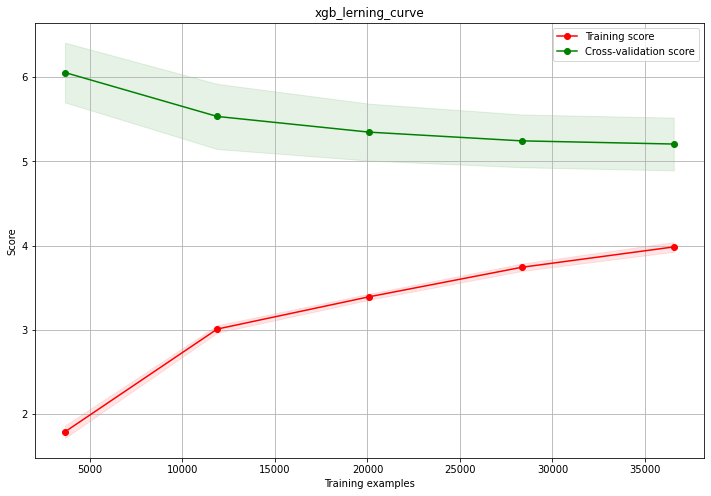

In [20]:
plot_learning_curve(models[0][1], 'xgb_lerning_curve', train[feats], train['price'])

In [21]:
submit2(models, train, test, feats, 'ver7_cb_xgb.csv')

[12:51:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
submit for 2 models done


public score on Kaggle: 5.027